In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2024-02-15 09:15:58.898403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model_name = 'enformer'
data_dir = '../data/'
pdf_dir = utils.make_dir('pdfs/distance_test/')
test_results = f'../results/distance_test_True/{model_name}_10/'

In [3]:
tile_coords = pd.read_csv(f'../results/summary_csvs/enformer/sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [4]:
cre_df = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')


In [5]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       41
           silencing  Silencer       57
K562       enhancing  Enhancer       74
           silencing  Silencer      222
PC-3       enhancing  Enhancer       35
           silencing  Silencer       97
Name: seq_id, dtype: int64

In [6]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


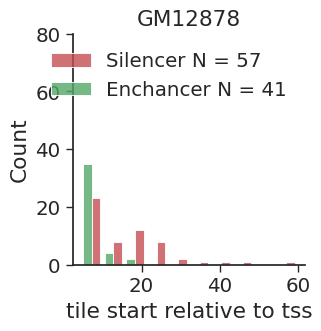

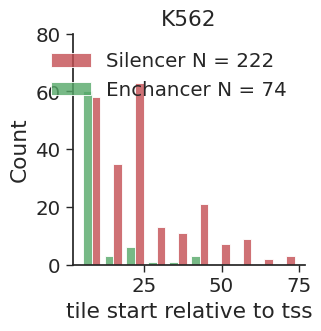

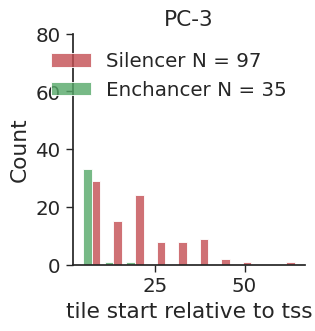

In [26]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[3,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    plt.savefig(f"{pdf_dir}/frequency_vs_distance_{cell}.pdf")
    plt.show()

In [42]:
res['mean_control'].shape

(896, 3)

In [11]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [79]:
cre_df_cell['control']

394      6.459833
395      7.155712
396      2.520494
397      0.058883
398      2.107587
          ...    
521     86.673460
522    119.657814
523    126.927380
524    114.633224
525    137.703860
Name: control, Length: 132, dtype: float64

In [89]:
result_normalized_effects = []
all_norm_effects = []
raw_preds = {}
for i, cell_line in enumerate(cell_lines):
    raw_preds[cell_line] = []
    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]
    cre_df_cell.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df_cell['tile_start'].values ])
    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = row['control'] #res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        if row['context'] == 'enhancing':
            CRE_norm_effects = (test - control) / row['wt']
        else:
            CRE_norm_effects = (test - control) / control
            

        norm_effects = test / np.max(test)
        all_norm_effects.append(norm_effects)
        df = pd.DataFrame([norm_effects, CRE_norm_effects, cre_tiles_starts_abs]).T
        df.columns = ['Fold change over control', "CRE sufficiency effect", 'Binned distance (Kb)']
        df['Normalized CRE effect (control)'] = row['Normalized CRE effect']
        raw_preds[cell_line].append(test)
        df['cell line'] = cell_line
        df['control'] = control
        df['enf_data_id'] = f'{row["seq_id"]}_{tile_start}_{tile_end}'
        df['context'] = row['context']
        df['tile class'] = row['tile class']
        result_normalized_effects.append(df)

result_normalized_effects = pd.concat(result_normalized_effects)

132it [00:00, 706.70it/s]
98it [00:00, 713.51it/s]
296it [00:00, 717.12it/s]


In [86]:
# my_palette = {}
# tile_labels = {}
# for i, row in n_df.iterrows():
#     c = 'g' if i=='Enhancer' else 'r'
#     my_palette[f'{i} N={row.iloc[0]}'] = c
#     k = 'Enhancer' if 'Enh' in k else 'Silencer'
#     tile_labels[k] = f'{i} N={row.iloc[0]}'

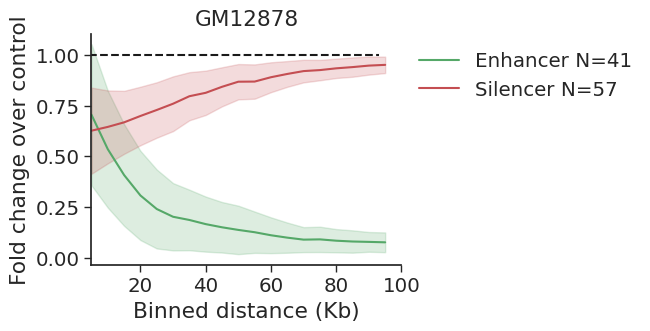

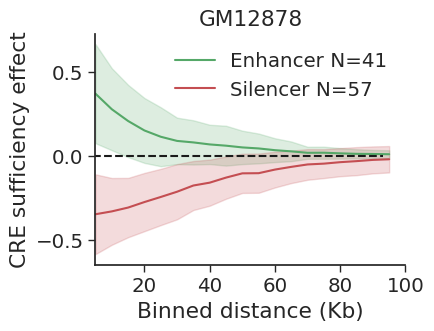

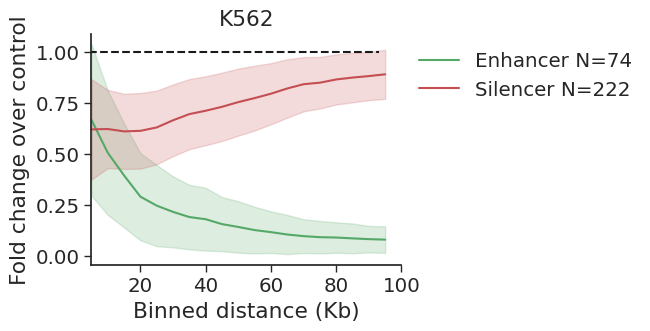

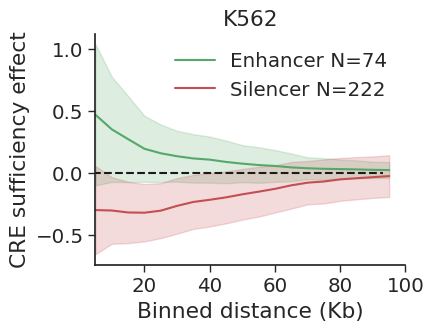

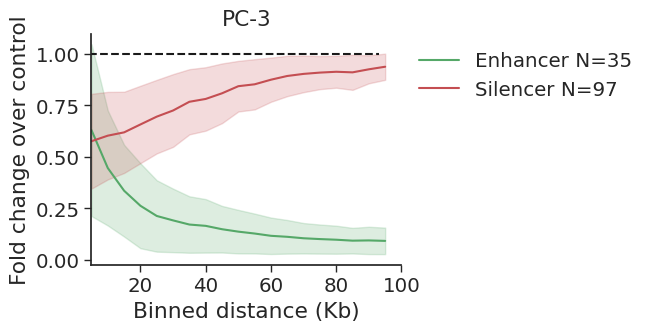

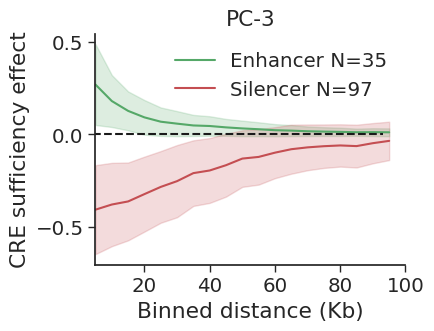

In [94]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    for y, hline_y, filename_label in [['Fold change over control', 1, 'fold_change'], ["CRE sufficiency effect", 0, 'cre_effect']]:

        fig, ax = plt.subplots(1, figsize=[4, 3])
        sns.lineplot(data=df, x='Binned distance (Kb)', y=y, hue='tile class', ci='sd',
                  palette=my_palette, ax=ax)
        ax.plot([1, 93],[hline_y, hline_y], '--k')
        ax.set_xlim([5,100])
        # ax.set_ylim(0,1.75)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title(cell_line)
    
        plt.legend(frameon=False, bbox_to_anchor=[1,1])
        plt.savefig(f"{pdf_dir}/distance_test_{filename_label}_{cell_line}.pdf")
        plt.show()

In [114]:
result_normalized_effects.to_csv('../results/summary_csvs/enformer/distance_test.csv')